In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

2023-06-17 15:41:50.213662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_LIB = './2d_images/'
MASK_LIB = './2d_masks/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
SEED=42

In [1]:
def list_all_files(directory):
    files = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            files.append(os.path.join(dirpath, filename))
    return files


In [5]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.tif']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

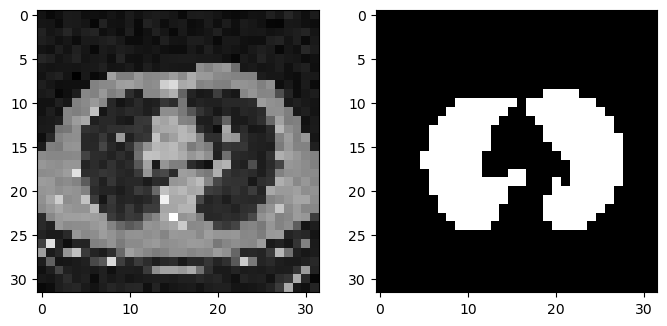

In [6]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [7]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


In [9]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)

2023-06-17 15:43:14.760078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)                 
model = Model(input_layer, output_layer)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 8)    80          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 16)   1168        ['max_pooling2d[0][0]']          
                                                                                              

In [12]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

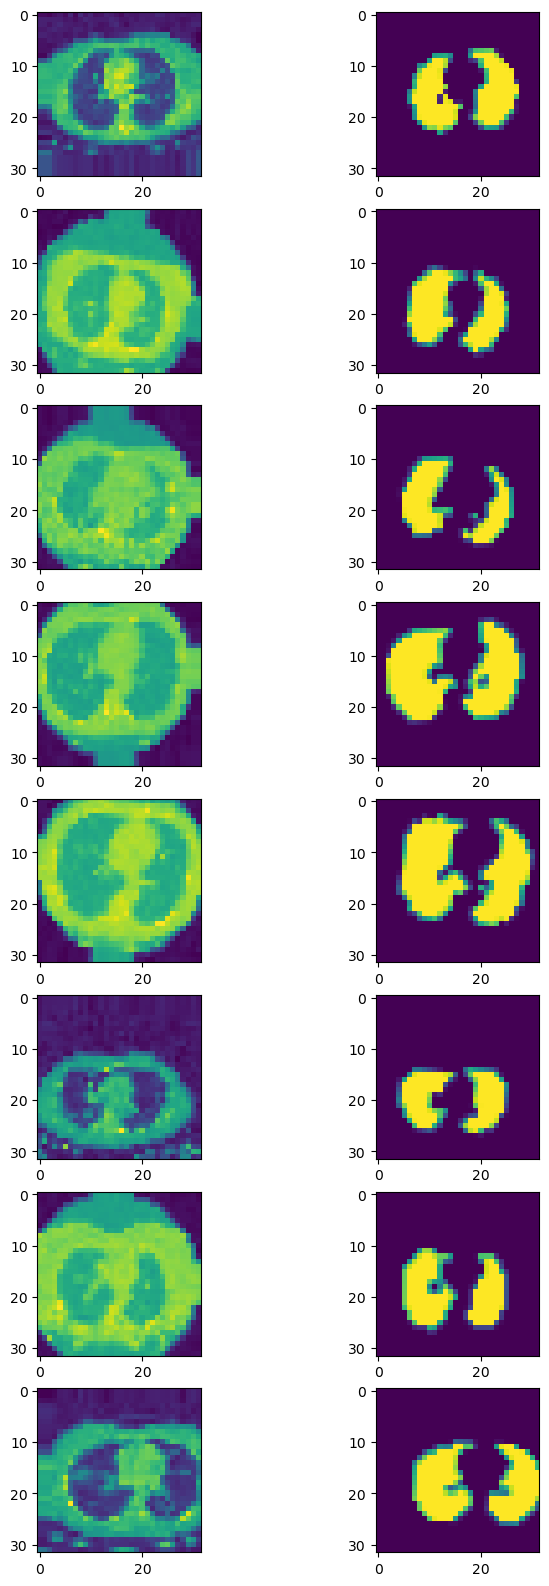

In [13]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [15]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [16]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_dice_coef', save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [17]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, annealer])

/var/folders/11/hmlctngd0358zsklxrk4zvfm0000gn/T/ipykernel_12036/4015351050.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(my_generator(x_train, y_train, 8),


Epoch 1/10
200/200 - 3s - loss: 0.3854 - dice_coef: 0.4865 - val_loss: 0.1813 - val_dice_coef: 0.7719 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 2/10
200/200 - 2s - loss: 0.1950 - dice_coef: 0.7547 - val_loss: 0.1489 - val_dice_coef: 0.8308 - lr: 8.0000e-04 - 2s/epoch - 9ms/step
Epoch 3/10
200/200 - 2s - loss: 0.1624 - dice_coef: 0.8016 - val_loss: 0.1184 - val_dice_coef: 0.8461 - lr: 6.4000e-04 - 2s/epoch - 9ms/step
Epoch 4/10
200/200 - 2s - loss: 0.1507 - dice_coef: 0.8183 - val_loss: 0.1143 - val_dice_coef: 0.8640 - lr: 5.1200e-04 - 2s/epoch - 9ms/step
Epoch 5/10
200/200 - 2s - loss: 0.1447 - dice_coef: 0.8276 - val_loss: 0.1031 - val_dice_coef: 0.8668 - lr: 4.0960e-04 - 2s/epoch - 9ms/step
Epoch 6/10
200/200 - 2s - loss: 0.1373 - dice_coef: 0.8350 - val_loss: 0.0971 - val_dice_coef: 0.8720 - lr: 3.2768e-04 - 2s/epoch - 9ms/step
Epoch 7/10
200/200 - 2s - loss: 0.1354 - dice_coef: 0.8387 - val_loss: 0.0951 - val_dice_coef: 0.8754 - lr: 2.6214e-04 - 2s/epoch - 10ms/step
Epoch 8/10
200/

In [18]:
model.load_weights('lung.h5')


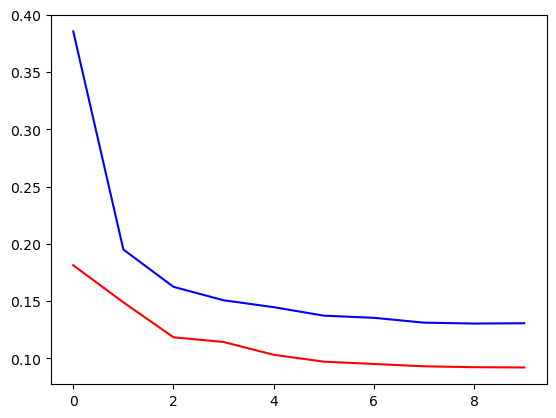

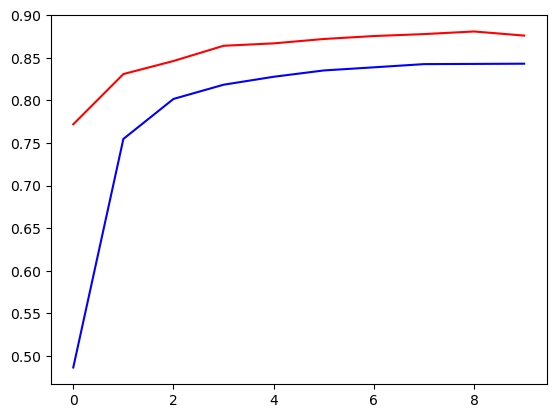

In [19]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

1/1 [==============================] - 0s 109ms/step


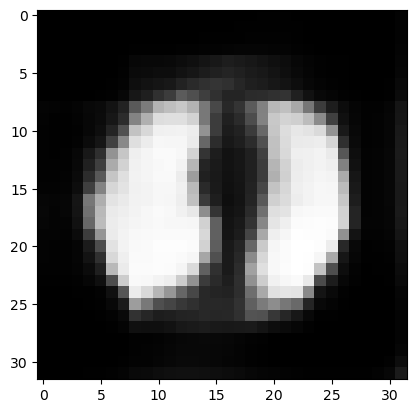

In [20]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

5/5 [==============================] - 0s 6ms/step


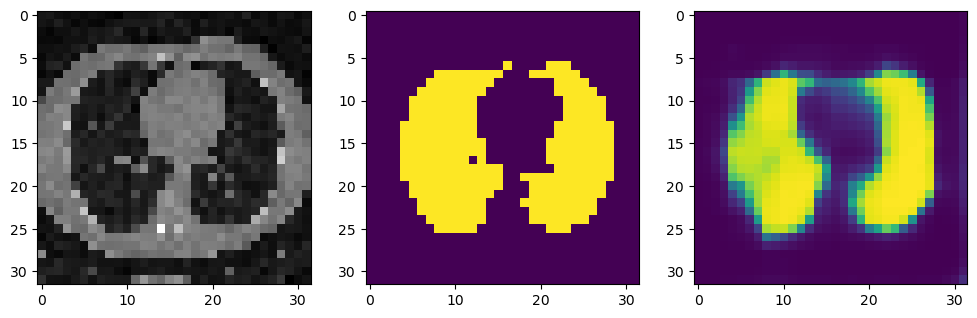

In [21]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])
